**Michael Grossberg**
**July 12, 2019**

# Study in remapping GOES-16 and GOES17 problems with pyresample

In this notebook I will show some problems with using pyresample to remap. I will use cartopy which does not allow me to pull the data of the remapping out but will let me remap. And then I will use pyresample and get incorrect answers for GOES-16 and GOES-17 remapped to CONUS using Plate Carree and Albers Equal Area projections.

Most of the code comes from Brian Blaylock's github repo.
https://github.com/blaylockbk/pyBKB_v3

Data is here: https://github.com/adomakor412/GOEScode

GOES files can be downloaded from Amazon S3:
- Amazon page: https://registry.opendata.aws/noaa-goes/
- My download page: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/generic_AWS_download.cgi?DATASET=noaa-goes16

In [11]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import pyproj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import os
import os.path as op
import sys
import metpy
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
DATAPATH= './'
#sys.path.append('../pyBKB_v3')
#rom BB_GOES.get_GOES import get_GOES_nearesttime

In [12]:
G16 = xarray.open_dataset(op.join(DATAPATH,'OR_ABI-L2-MCMIPC-M6_G16_s20191771701200_e20191771703573_c20191771704096.nc')) #using metpy for reading satellite or weather data
G17 = xarray.open_dataset(op.join(DATAPATH,'OR_ABI-L2-MCMIPC-M6_G17_s20191771701197_e20191771703570_c20191771704070.nc'))

In [13]:
def make_RGB(C, night_IR=True):
    
    """
    C        - GOES file opened with xarray
    night_IR - Set nighttime pixels as clean IR channel (channel 13, 10.3 um).
    """
    
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C02'].data
    G = C['CMI_C03'].data
    B = C['CMI_C01'].data

    ######################################################################
    #

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    ######################################################################
    #

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    ######################################################################
    #

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)
    
    # The RGB array with the raw veggie band
    RGB_veggie = np.dstack([R, G, B])

    # The RGB array for the true color image
    RGB = np.dstack([R, G_true, B])
    
    if night_IR:
        cleanIR = C['CMI_C13'].data
        # Normalize the channel between a range. e.g. cleanIR =
        # (cleanIR-minimum)/(maximum-minimum)
        cleanIR = (cleanIR-90)/(313-90)

        # Apply range limits for each channel. RGB values must be between 0 and 1
        cleanIR = np.clip(cleanIR, 0, 1)

        # Invert colors so that cold clouds are white
        cleanIR = 1 - cleanIR

        # Lessen the brightness of the coldest clouds so they don't appear so bright
        # when we overlay it on the true color image
        cleanIR = cleanIR/1.4
    
        # Fill RGB where true color is black with IR values.
        RGB = np.dstack([np.maximum(R, cleanIR),
                         np.maximum(G_true, cleanIR),
                         np.maximum(B, cleanIR)])
        
    return RGB

## Plot Loaded data
Without remapping this is close to the data as loaded by the netcdf readers.

In [14]:
# Make RGB for both GOES16 and GOES17
rgb16 = make_RGB(G16)
rgb17 = make_RGB(G17)

scan_start_16 = datetime.strptime(G16.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
scan_start_17 = datetime.strptime(G17.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

(-0.5, 2499.5, 1499.5, -0.5)

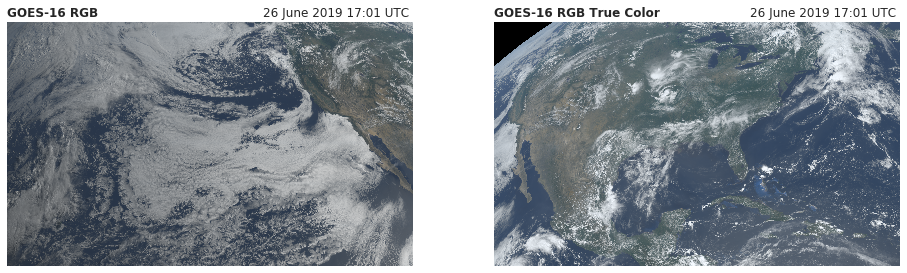

In [15]:
fig_1, (ax1_1, ax2_1) = plt.subplots(1,2, figsize=(16,6))

# The GOES-17 RGB
ax1_1.imshow(rgb17)
ax1_1.set_title('GOES-16 RGB', fontweight='semibold', loc='left', fontsize=12);

ax1_1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1_1.axis('off')

# The GOES-16 RGB
ax2_1.imshow(rgb16)
ax2_1.set_title('GOES-16 RGB True Color', fontweight='semibold', loc='left', fontsize=12);
ax2_1.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax2_1.axis('off')

## Plot Geostationary figures

Here the projections are extracted from the data. Then the data is plotted in the geostationary projection, essentially simulating "as viewed by the imager".

In [16]:
# Generate cartopy projection object with metpy parser
# NOTE: Don't re-run this cell after it has run or it won't work.
dat16 = G16.metpy.parse_cf('CMI_C02')
dat17 = G17.metpy.parse_cf('CMI_C02')

# Geostationary projections
geos16 = dat16.metpy.cartopy_crs
geos17 = dat17.metpy.cartopy_crs

x16 = dat16.x
y16 = dat16.y

x17 = dat17.x
y17 = dat17.y

# Cartopy extents go [x_min, x_max, y_min, y_max]
cartopy_extent_goes16 = (x16.min(), x16.max(), y16.min(), y16.max())
cartopy_extent_goes17 = (x17.min(), x17.max(), y17.min(), y17.max())

/opt/home/adomakor412/.conda/envs/GOESCode/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/adomakor412/.conda/envs/GOESCode/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


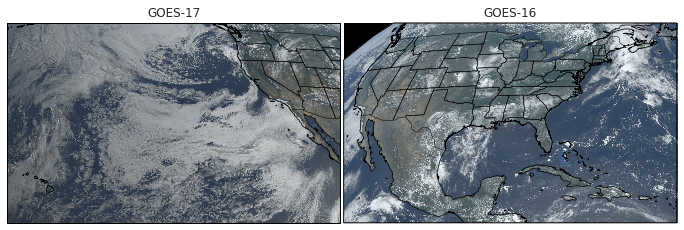

In [17]:
fig_2 = plt.figure(figsize=(12, 5))

ax1_2 = fig_2.add_subplot(1, 2, 1, projection=geos17)
ax2_2 = fig_2.add_subplot(1, 2, 2, projection=geos16)


## GOES 17
ax1_2.imshow(rgb17, origin='upper', extent=cartopy_extent_goes17,
           transform=geos17)
ax1_2.coastlines(resolution='50m', color='black', linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1_2.set_title('GOES-17')

## GOES 16
ax2_2.imshow(rgb16, origin='upper', extent=cartopy_extent_goes16,
           transform=geos16)
ax2_2.coastlines(resolution='50m', color='black', linewidth=.75)
ax2_2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax2_2.set_title('GOES-16')

fig_2.subplots_adjust(wspace=.01)

# Plate Carree Cylindrical Projection (with Cartopy)
Zoomed on Utah in Plate Carree Projection. When these are checked against Google maps they read correctly so this looks like Cartopy is making the proper remapping.

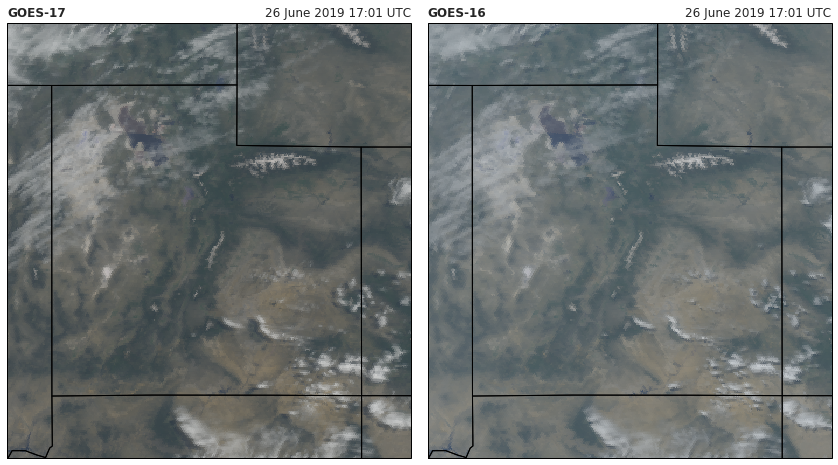

In [18]:
# This defines the target projection Plate Carree
pc = ccrs.PlateCarree()

Utah_lat_lon_extent = [-114.75, -108.25, 36, 43]
fig_3 = plt.figure(figsize=(15, 8))

ax1_3 = fig_3.add_subplot(1, 2, 1, projection=pc)
ax2_3 = fig_3.add_subplot(1, 2, 2, projection=pc)

ax1_3.set_extent(Utah_lat_lon_extent, crs=pc)
ax2_3.set_extent(Utah_lat_lon_extent, crs=pc)


# GOES17
ax1_3.imshow(rgb17, origin='upper',
           extent=cartopy_extent_goes17,
           transform=geos17,
           interpolation='none')
ax1_3.add_feature(ccrs.cartopy.feature.STATES)
ax1_3.set_title('GOES-17', loc='left', fontweight='bold')
ax1_3.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2_3.imshow(rgb16, origin='upper',
           extent=cartopy_extent_goes16,
           transform=geos16,
           interpolation='none')
ax2_3.add_feature(ccrs.cartopy.feature.STATES)
ax2_3.set_title('GOES-16', loc='left', fontweight='bold')
ax2_3.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


fig_3.subplots_adjust(wspace=.01)

## Plate Carree with Pyresample

Is possible to extract the proj4 parameters from the mapping and reproduce the resampling using pyresample. In this way we could get the array of values to be used in comparison for CAL-VAL. We have to be incredibly careful with the extents to make sure that everything is consistent.

In [19]:
goes16_params = geos16.proj4_params
print(goes16_params)

{'a': 6378137.0, 'b': 6356752.31414, 'rf': 298.2572221, 'proj': 'geos', 'lon_0': -75.0, 'lat_0': 0.0, 'h': 35786023.0, 'x_0': 0, 'y_0': 0, 'units': 'm', 'sweep': 'x'}


In [20]:
goes17_params = geos17.proj4_params
print(goes17_params)

{'a': 6378137.0, 'b': 6356752.31414, 'rf': 298.2572221, 'proj': 'geos', 'lon_0': -137.0, 'lat_0': 0.0, 'h': 35786023.0, 'x_0': 0, 'y_0': 0, 'units': 'm', 'sweep': 'x'}


In [21]:
pc_params = pc.proj4_params
print(pc_params)

{'ellps': 'WGS84', 'a': 57.29577951308232, 'proj': 'eqc', 'lon_0': 0.0}


In [22]:
# Extent from pc_params consitant with Cartopy's "pc" projection
# The extend that pyresample uses is [x_min, y_min, x_max, y_max] 
#      **rather than** [x_min,x_max,y_min,y_max]
#      as is used in Cartopy
prj_pc = pyproj.Proj(pc_params) 
ll_pc = prj_pc(Utah_lat_lon_extent[0], Utah_lat_lon_extent[2]) # lower left coordinates
ur_pc = prj_pc(Utah_lat_lon_extent[1], Utah_lat_lon_extent[3]) # upper right coordinates
extent_pc = ll_pc + ur_pc
print(prj_pc.srs)
print(extent_pc)

+units=m +ellps=WGS84 +a=57.29577951308232 +proj=eqc +lon_0=0.0 
(-114.75000000000001, 36.0, -108.25, 43.0)


We need to compute the extent of the target projection for remapping.

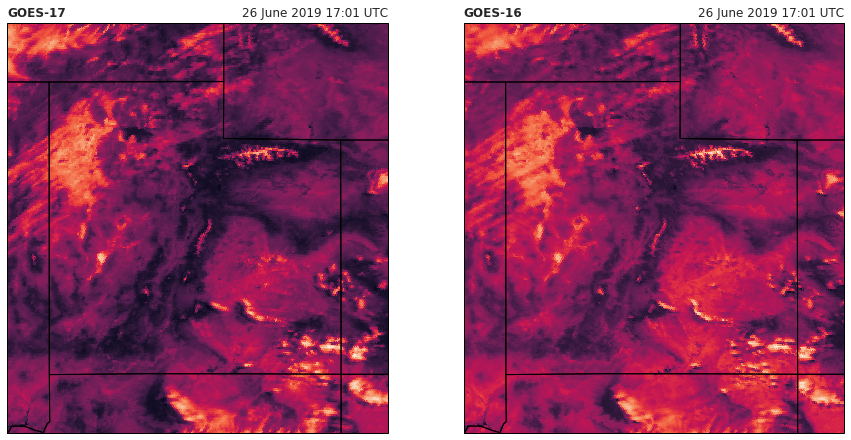

In [23]:
# Redchannels only
R16 = rgb16[:,:,0]
R17 = rgb17[:,:,0]

# Float conversion needed and re-ordering of extent to match pyresample form [x_min, y_min, x_max, y_max] 
pyresample_extent_goes17 = [float(x17.min()), float(y17.min()), float(x17.max()), float(y17.max())]
pyresample_extent_goes16 = [float(x16.min()), float(y16.min()),float(x16.max()),float(y16.max())]

# Float conversion needed and re-ordering of extent to match pyresample form [x_min, y_min, x_max, y_max] 
goes17_area = geometry.AreaDefinition('GOES-17', 'CONUS',
                                'GOES-17', goes17_params,
                                R17.shape[1], R17.shape[0],
                              pyresample_extent_goes17)

# Float conversion needed and re-ordering of extent to match pyresample form [x_min, y_min, x_max, y_max] 
goes16_area = geometry.AreaDefinition('GOES-16', 'CONUS',
                                'GOES-16', goes16_params,
                                R16.shape[1], R16.shape[0],
                              pyresample_extent_goes16)

NUM_ROWS, NUM_COLS = 800, 800 # We pick number of rows and columns

area_pc_def = geometry.AreaDefinition('areaD', 'CONUS-UTAH', 'areaD',
                                      pc_params,
                                      NUM_ROWS,NUM_COLS,
                                      extent_pc)

# Here is where we use pyresample RATHER than Cartopy to transform goes16/17 to Plate Carree
geos17_con_nn = image.ImageContainerNearest(R17, goes17_area, radius_of_influence=50000)
area_17_con_nn = geos17_con_nn.resample(area_pc_def)
image_pc_17 = area_17_con_nn.image_data

geos16_con_nn = image.ImageContainerNearest(R16, goes16_area, radius_of_influence=50000)
area_16_con_nn = geos16_con_nn.resample(area_pc_def)
image_pc_16 = area_16_con_nn.image_data


Utah_lat_lon_extent = [-114.75, -108.25, 36, 43]
fig_4 = plt.figure(figsize=(15, 8))

ax1_4 = fig_4.add_subplot(1, 2, 1, projection=pc)
ax2_4 = fig_4.add_subplot(1, 2, 2, projection=pc)

ax1_4.set_extent(Utah_lat_lon_extent, crs=pc)
ax2_4.set_extent(Utah_lat_lon_extent, crs=pc)


# GOES17
ax1_4.imshow(image_pc_17, origin='upper',
           interpolation='none', extent=Utah_lat_lon_extent, transform=pc)
ax1_4.add_feature(ccrs.cartopy.feature.STATES)
ax1_4.set_title('GOES-17', loc='left', fontweight='bold')
ax1_4.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2_4.imshow(image_pc_16, origin='upper',
           interpolation='none', extent=Utah_lat_lon_extent, transform=pc)
ax2_4.add_feature(ccrs.cartopy.feature.STATES)
ax2_4.set_title('GOES-16', loc='left', fontweight='bold')
ax2_4.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


## Albers Equal Area

The pixels in Plate Carree are actually not exactly the same size. It is not an equal area projection. We are going to redo in Albers Equal Area to make sure we can run another projection.

In [24]:
# The proj4 string was copied from a recommendation for the US map
prj_aea = pyproj.Proj(
    "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 "+
    "+x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs")
aea = ccrs.AlbersEqualArea(globe=ccrs.Globe(ellipse='GRS80'),
                           central_longitude=-96,central_latitude=37.5,
                           standard_parallels=(29.5,45.5))
aea_params = aea.proj4_params
print(aea_params)

{'ellps': 'GRS80', 'proj': 'aea', 'lon_0': -96, 'lat_0': 37.5, 'x_0': 0.0, 'y_0': 0.0, 'lat_1': 29.5, 'lat_2': 45.5}


{'ellps': 'GRS80', 'proj': 'aea', 'lon_0': -96, 'lat_0': 37.5, 'x_0': 0.0, 'y_0': 0.0, 'lat_1': 29.5, 'lat_2': 45.5}


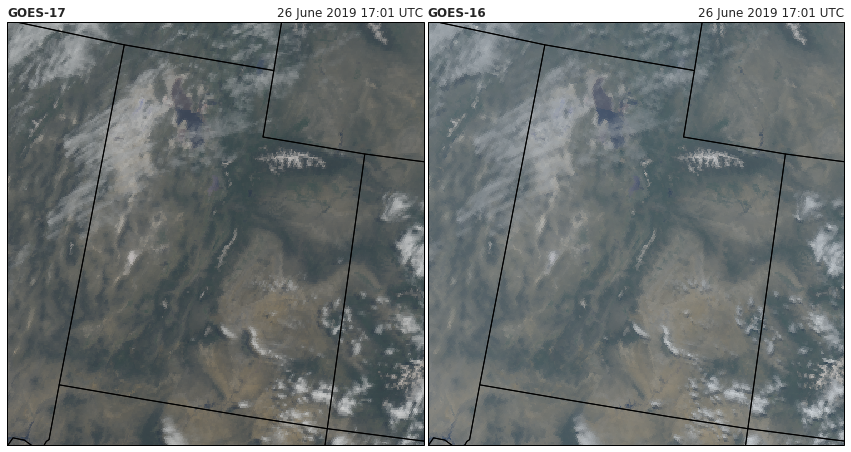

In [26]:
# This gives good results 

a_AEA = prj_aea(Utah_lat_lon_extent[0], Utah_lat_lon_extent[2]) # lower left coordinates
b_AEA = prj_aea(Utah_lat_lon_extent[1], Utah_lat_lon_extent[3]) # upper right coordinates
pyresample_extent_AEA = a_AEA + b_AEA
cartopy_extent_AEA = [pyresample_extent_AEA[0], pyresample_extent_AEA[2], pyresample_extent_AEA[1], pyresample_extent_AEA[3]]

fig_5 = plt.figure(figsize=(15, 8))

ax1_5 = fig_5.add_subplot(1, 2, 1, projection=aea)
ax2_5 = fig_5.add_subplot(1, 2, 2, projection=aea)

ax1_5.set_extent(cartopy_extent_AEA, crs=aea)
ax2_5.set_extent(cartopy_extent_AEA, crs=aea)


# GOES17
ax1_5.imshow(rgb17, origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
ax1_5.add_feature(ccrs.cartopy.feature.STATES)
ax1_5.set_title('GOES-17', loc='left', fontweight='bold')
ax1_5.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2_5.imshow(rgb16, origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
ax2_5.add_feature(ccrs.cartopy.feature.STATES)
ax2_5.set_title('GOES-16', loc='left', fontweight='bold')
ax2_5.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');

fig_5.subplots_adjust(wspace=.01)
print(aea.proj4_params)

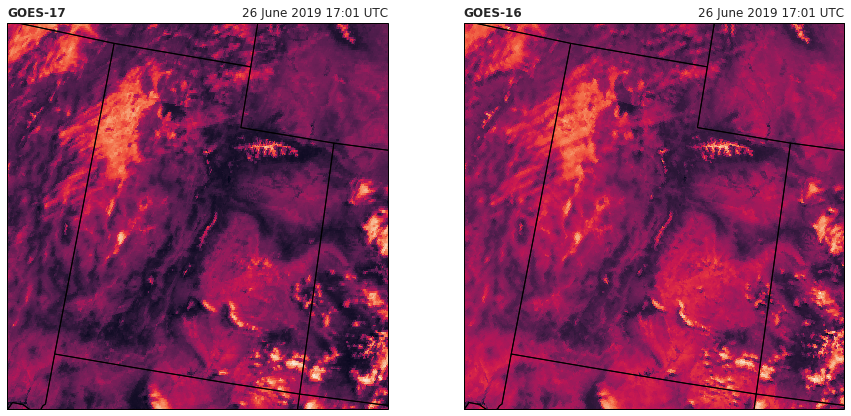

In [27]:
area_aea_def = geometry.AreaDefinition('areaD', 'CONUS-UTAH', 'areaD',
                                  {'ellps': 'GRS80', 'proj': 'aea', 
                                   'lon_0': -96, 'lat_0': 37.5, 
                                   'x_0': 0.0, 'y_0': 0.0, 
                                   'lat_1': 29.5, 'lat_2': 45.5},
                                    800, 800,
                                   pyresample_extent_AEA)

# Here we are using pyresample for the remapping
area_aea_con_nn = geos17_con_nn.resample(area_aea_def)
image_aea_17 = area_aea_con_nn.image_data

area_aea_con_nn = geos16_con_nn.resample(area_aea_def)
image_aea_16= area_aea_con_nn.image_data

fig_5 = plt.figure(figsize=(15, 8))

ax1_5 = fig_5.add_subplot(1, 2, 1, projection=aea)
ax2_5 = fig_5.add_subplot(1, 2, 2, projection=aea)

ax1_5.set_extent(cartopy_extent_AEA, crs=aea)
ax2_5.set_extent(cartopy_extent_AEA, crs=aea)


# GOES17
ax1_5.imshow(image_aea_17, origin='upper',
           interpolation='none', extent=cartopy_extent_AEA, transform=aea)
ax1_5.add_feature(ccrs.cartopy.feature.STATES)
ax1_5.set_title('GOES-17', loc='left', fontweight='bold')
ax1_5.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2_5.imshow(image_aea_16, origin='upper',
           interpolation='none', extent=cartopy_extent_AEA, transform=aea)
ax2_5.add_feature(ccrs.cartopy.feature.STATES)
ax2_5.set_title('GOES-16', loc='left', fontweight='bold')
ax2_5.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


## Comparing Data Points

Now that we have the data array 'image_aea_16' and 'image_aea_17' which corresponds to the same grid, we can scatter plot it. But wer first need to check how many data points there are since there may be too many to scatter plot. The goal is now to get 5,000 points from each and see how the scatterplot/correllation looks. We will also want to see which points we have sampled from. We need to be able to go back and forth from data to map and back.


In [28]:
# Flatten the data into one long vector and count pixels
num_pixels = len(image_aea_16.ravel())
print(num_pixels)

640000


In [29]:
NUM_SAMPLES=5000 #All caps because this is a "constant" we set.
RANDOM_SEED = 42 # Alwasy seed our choices

inds_in_order = np.arange(num_pixels)

np.random.seed(RANDOM_SEED)
shuffled_pixel_inds = np.random.permutation(inds_in_order)
sample_inds = shuffled_pixel_inds[0:NUM_SAMPLES]
goes16_val_samples = image_aea_16.ravel()[sample_inds]
goes17_val_samples = image_aea_17.ravel()[sample_inds]

With a representive 5000 points were not ready so see how the relate in GOES-16 and GOES-17

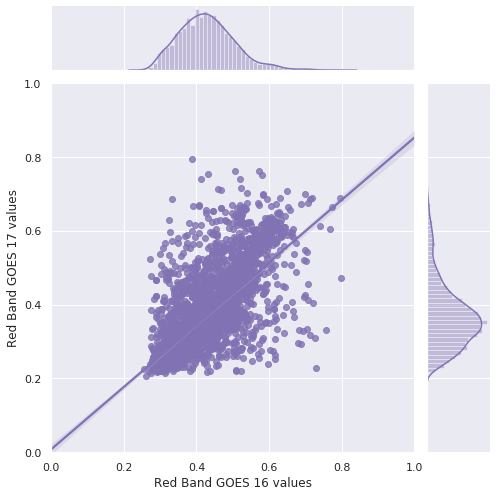

In [30]:



goesdata = pd.DataFrame({'Red Band GOES 17 values':goes17_val_samples,
                        'Red Band GOES 16 values':goes16_val_samples})

g = sns.jointplot("Red Band GOES 16 values", "Red Band GOES 17 values", data=goesdata, kind="reg",
                  xlim=(0, 1), ylim=(0, 1), color="m", height=7)

The regression line shows that there is a bias, and that goes 17 is somewhat darker thatn goes 16 for this image. 
If we scatter plot without being careful about the alpha it looks like the data is actually very weakly correlated and the error between the two graphs is high.  That is misleading. There is a very tight error envelope around the least square fit line. We can see that most of the data actually is pretty close to the line if we make the dots much more transparent.

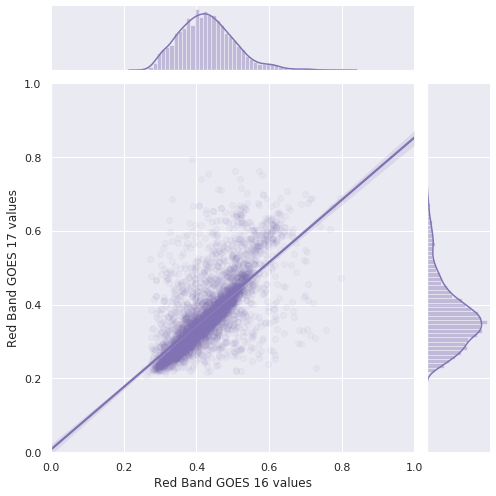

In [31]:
goesdata = pd.DataFrame({'Red Band GOES 17 values':goes17_val_samples,
                        'Red Band GOES 16 values':goes16_val_samples})

g = sns.jointplot("Red Band GOES 16 values", "Red Band GOES 17 values", data=goesdata, kind="reg",
                  xlim=(0, 1), ylim=(0, 1), color="m", height=7, scatter_kws={"alpha": 0.05})

Two things to note. It does not look like there is any strong bias in intensity as to when the error is large. It could be a "dark" or "light" pixel. Light ones have a bit more change of being a big error. How do we find the big errors? First we need the regression line. Lets assume we are predicting GOES 17 givne GOES 16, and we use stats model.

In [32]:
X = sm.add_constant(goes16_val_samples)
y = goes17_val_samples
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5106.
Date:                Fri, 19 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:18:25   Log-Likelihood:                 6682.8
No. Observations:                5000   AIC:                        -1.336e+04
Df Residuals:                    4998   BIC:                        -1.335e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.005      1.532      0.1

In [33]:
shape_16 = image_aea_16.shape # save the shape
X_all_16 = sm.add_constant(image_aea_16.ravel())
errors_image = np.abs(results.predict(X_all_16)-image_aea_17.ravel()).reshape(shape_16)

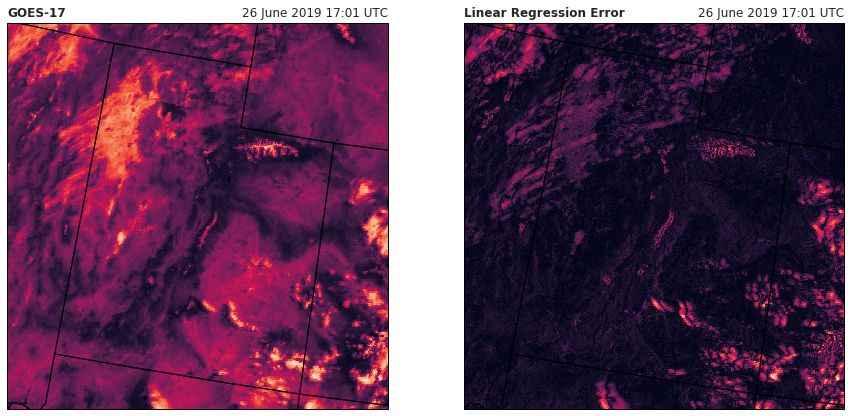

In [34]:
fig_6 = plt.figure(figsize=(15, 8))

ax1_6 = fig_6.add_subplot(1, 2, 1, projection=aea)
ax2_6 = fig_6.add_subplot(1, 2, 2, projection=aea)

ax1_6.set_extent(cartopy_extent_AEA, crs=aea)
ax2_6.set_extent(cartopy_extent_AEA, crs=aea)


# GOES17
ax1_6.imshow(image_aea_17, origin='upper',
           interpolation='none', extent=cartopy_extent_AEA, transform=aea)
ax1_6.add_feature(ccrs.cartopy.feature.STATES)
ax1_6.set_title('GOES-17', loc='left', fontweight='bold')
ax1_6.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2_6.imshow(errors_image, origin='upper',
           interpolation='none', extent=cartopy_extent_AEA, transform=aea)
ax2_6.add_feature(ccrs.cartopy.feature.STATES)
ax2_6.set_title('Linear Regression Error', loc='left', fontweight='bold')
ax2_6.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


What we see from the regression error is that pretty clearly lots of the large errors are due to cloud motion. Particularly in the lower left corner, there are tell tale features that look "doubled." This is exactly what happends when a cloud moves. The cloud which moved between goes 16 and goes 17 creates an error both where it is in goes 16, and also goes 17. Note that these clouds have shadows which move as well. There are also some more ambiguous data sets in the upper left. These may be clouds ore just glare off ground snow. 

Another possible source of error could be mis-regstration. That is what we think is a pixel in one image is slightly off and shifted with respect to the other image. The evidence against this is that if that were the case it would also create larger errors on the boundary between dark patches and lighter patches on the ground. However, we don't see that. We do see errors in the mountains though. This could be due low fog and clouds in the mounains or again it could be due to viewing angle and glare off the snow which might depend on the different viewing angle of goes16 and goes 17. When we do carefully perform calibaration between the two, we will need to identify clouds and it may be neccessary to exclude clouds from comparson since they move. We may also need to identify locations on the ground which have snow or water and may vary due to viewing angle. We want to measure **error** due to the difference between the sensors, not real differences in radiances due to change in viewing angle and/or time.

In order to practice tracking down error, we will now will locate the location of the top 5% errors from our samples and map them back to the image.

In [35]:
errors = abs(results.predict(X)-y)
five_percent_quantiles = np.quantile(errors,.95)# Largest 5% errors
big_error_sample_inds = (errors > five_percent_quantiles).nonzero() # These are the indices with respect to the samples
big_error_image_inds = sample_inds[big_error_sample_inds]

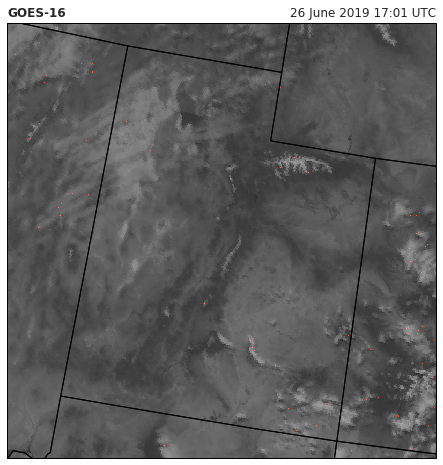

In [36]:
# Greyscale image where we color the locations of the big errors from the sample
# Here we make the image rather than use a color map
chanR=image_aea_16*0.8 # Darken by a bit
chanG=image_aea_16*0.8 # Darken by a bit
chanB=image_aea_16*0.8 # Darken by a bit
chanR = chanR.ravel()
chanR[big_error_image_inds]=1.0
chanR = chanR.reshape(chanG.shape)
sample_location_image = np.dstack([chanR,chanG,chanB])

fig_7 = plt.figure(figsize=(15, 8))

ax1_7 = fig_7.add_subplot(1, 1, 1, projection=aea)

ax1_7.set_extent(cartopy_extent_AEA, crs=aea)

# GOES16
ax1_7.imshow(sample_location_image, origin='upper',
           interpolation='none', extent=cartopy_extent_AEA, transform=aea)
ax1_7.add_feature(ccrs.cartopy.feature.STATES)
ax1_7.set_title('GOES-16', loc='left', fontweight='bold')
ax1_7.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


The red points are showing up where they should but they are too small. It would be better to scatter plot the data onto the map. For this we need the Albers Equal Area X and Y for every point. Here we will go back to a color map.

In [37]:
# This gives the X,Y index for each image points
XXaea, YYaea = np.meshgrid(np.linspace(cartopy_extent_AEA[0],cartopy_extent_AEA[1],NUM_ROWS),
                           np.linspace(cartopy_extent_AEA[2],cartopy_extent_AEA[3],NUM_COLS))

xcords = (XXaea.ravel())[big_error_image_inds]
ycords = (YYaea.ravel())[big_error_image_inds]

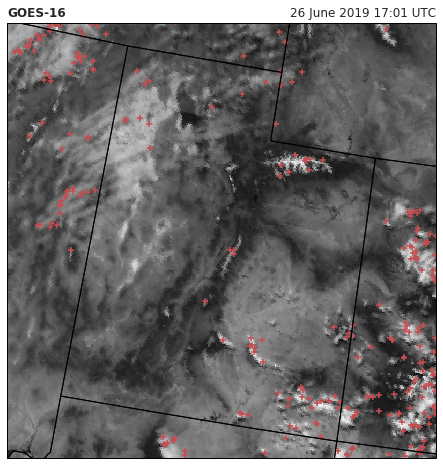

In [38]:
fig_8 = plt.figure(figsize=(15, 8))

ax1_8 = fig_8.add_subplot(1, 1, 1, projection=aea)

ax1_8.set_extent(cartopy_extent_AEA, crs=aea)

# GOES16
# Hack because I can't flip the map and the coordinates independently
y_max=max(ax1_8.get_ylim())
ax1_8.scatter(xcords,-ycords+y_max,c='r',marker='+')
#ax1_8.set_ylim(max(ax1_8.get_ylim()), min(ax1_8.get_ylim()))
ax1_8.imshow(image_aea_16, origin='upper', cmap='gray',
           interpolation='none', extent=cartopy_extent_AEA, transform=aea)
ax1_8.add_feature(ccrs.cartopy.feature.STATES)
ax1_8.set_title('GOES-16', loc='left', fontweight='bold')
ax1_8.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


In [39]:
GRad16 = xarray.open_dataset(op.join(DATAPATH,'OR_ABI-L1b-RadC-M6C01_G16_s20191771401199_e20191771403572_c20191771404018.nc'))
GRad17 = xarray.open_dataset(op.join(DATAPATH,'OR_ABI-L1b-RadC-M6C01_G17_s20191771401196_e20191771403569_c20191771404008.nc'))
RAD16= GRad16['Rad'].data
RAD17= GRad17['Rad'].data

run_once=False # This is for the next cell

In [ ]:
# We are now switching to the radiance data since eventually this will be the main interest
# Now we are going to update to remap the radiance data the same way as before

# Float conversion needed and re-ordering of extent to match pyresample form [x_min, y_min, x_max, y_max] 
# Generate cartopy projection object with metpy parser
if not run_once:
    # NOTE: Don't re-run this cell after it has run or it won't work.
    dat16_rad = GRad16.metpy.parse_cf('Rad')
    dat17_rad = GRad17.metpy.parse_cf('Rad')
    run_once = True

# Geostationary projections
geos16_rad = dat16_rad.metpy.cartopy_crs
geos17_rad = dat17_rad.metpy.cartopy_crs

x16_rad = dat16_rad.x
y16_rad = dat16_rad.y

x17_rad = dat17_rad.x
y17_rad = dat17_rad.y

# Cartopy extents go [x_min, x_max, y_min, y_max]
cartopy_extent_goes16_rad = (x16_rad.min(), x16_rad.max(),y16_rad.min(), y16_rad.max())
cartopy_extent_goes17_rad = (x17_rad.min(), x17_rad.max(),y17_rad.min(), y17_rad.max())

pyresample_extent_goes16_rad = (float(x16_rad.min()),float(y16_rad.min()), float(x16_rad.max()), float(y16_rad.max()))
pyresample_extent_goes17_rad = (float(x17_rad.min()),float(y17_rad.min()), float(x17_rad.max()), float(y17_rad.max()))


goes17_params_rad = geos17_rad.proj4_params
goes16_params_rad = geos16_rad.proj4_params

goes17_area_rad = geometry.AreaDefinition('GOES-17', 'CONUS',
                                'GOES-17', goes17_params_rad,
                                RAD17.shape[1], RAD17.shape[0],
                              pyresample_extent_goes17_rad)

# Float conversion needed and re-ordering of extent to match pyresample form [x_min, y_min, x_max, y_max] 
goes16_area_rad = geometry.AreaDefinition('GOES-16', 'CONUS',
                                'GOES-16', goes16_params_rad,
                                RAD16.shape[1], RAD16.shape[0],
                              pyresample_extent_goes16_rad)


geos17_con_nn_RAD = image.ImageContainerNearest(RAD17, goes17_area_rad, radius_of_influence=50000)
geos16_con_nn_RAD = image.ImageContainerNearest(RAD16, goes16_area_rad, radius_of_influence=50000)
# Here we are using pyresample for the remapping
area_aea_con_nn_RAD = geos17_con_nn_RAD.resample(area_aea_def)
image_aea_17_RAD = area_aea_con_nn_RAD.image_data

area_aea_con_nn_RAD = geos16_con_nn_RAD.resample(area_aea_def)
image_aea_16_RAD= area_aea_con_nn_RAD.image_data

fig_9 = plt.figure(figsize=(15, 8))

ax1_9 = fig_9.add_subplot(1, 2, 1, projection=aea)
ax2_9 = fig_9.add_subplot(1, 2, 2, projection=aea)

ax1_9.set_extent(cartopy_extent_AEA, crs=aea)
ax2_9.set_extent(cartopy_extent_AEA, crs=aea)


# GOES17
ax1_9.imshow(image_aea_17_RAD, origin='upper',
           interpolation='none', extent=cartopy_extent_AEA, transform=aea)
ax1_9.add_feature(ccrs.cartopy.feature.STATES)
ax1_9.set_title('GOES-17 Radiances', loc='left', fontweight='bold')
ax1_9.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2_9.imshow(image_aea_16_RAD, origin='upper',
           interpolation='none', extent=cartopy_extent_AEA, transform=aea)
ax2_9.add_feature(ccrs.cartopy.feature.STATES)
ax2_9.set_title('GOES-16  Radiances', loc='left', fontweight='bold')
ax2_9.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');




/opt/home/adomakor412/.conda/envs/GOESCode/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/adomakor412/.conda/envs/GOESCode/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


The above band 1 images are clearly pretty senstive to clouds. The clouds are lighting up rather intensely while the land is dark in both. Note there is considerable differences in the brightness of the clouds. Again this may be a viewing angle effect which makes it critical for us to compare where there aren't clouds so we better use goes 16 to mark clouds and exclude those points.